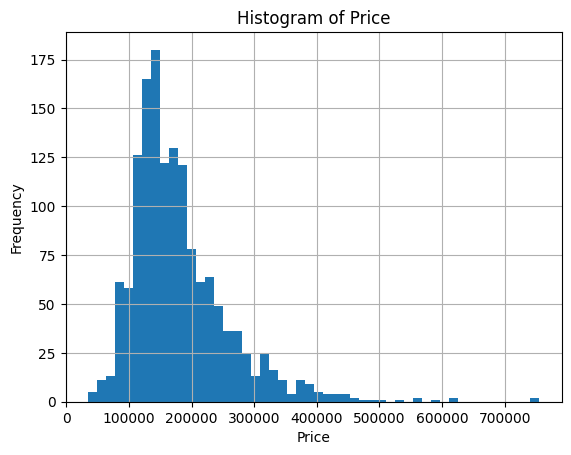

In [5]:
import pandas as pd

df = pd.read_csv('../../data/processed/filled_data.csv')
# historam of price
df['SalePrice'].hist(bins=50)
import matplotlib.pyplot as plt
plt.title('Histogram of Price')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.show()

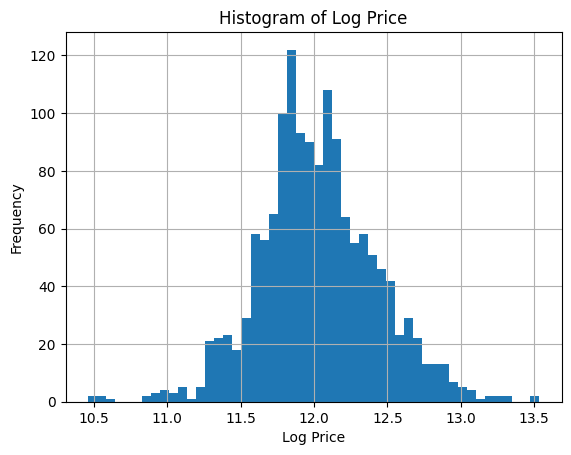

In [6]:
#Biến đổi log cho saleprice
import numpy as np
df['Log_SalePrice'] = np.log1p(df['SalePrice'])
# historam of log price
df['Log_SalePrice'].hist(bins=50)
plt.title('Histogram of Log Price')
plt.xlabel('Log Price')
plt.ylabel('Frequency')
plt.show()

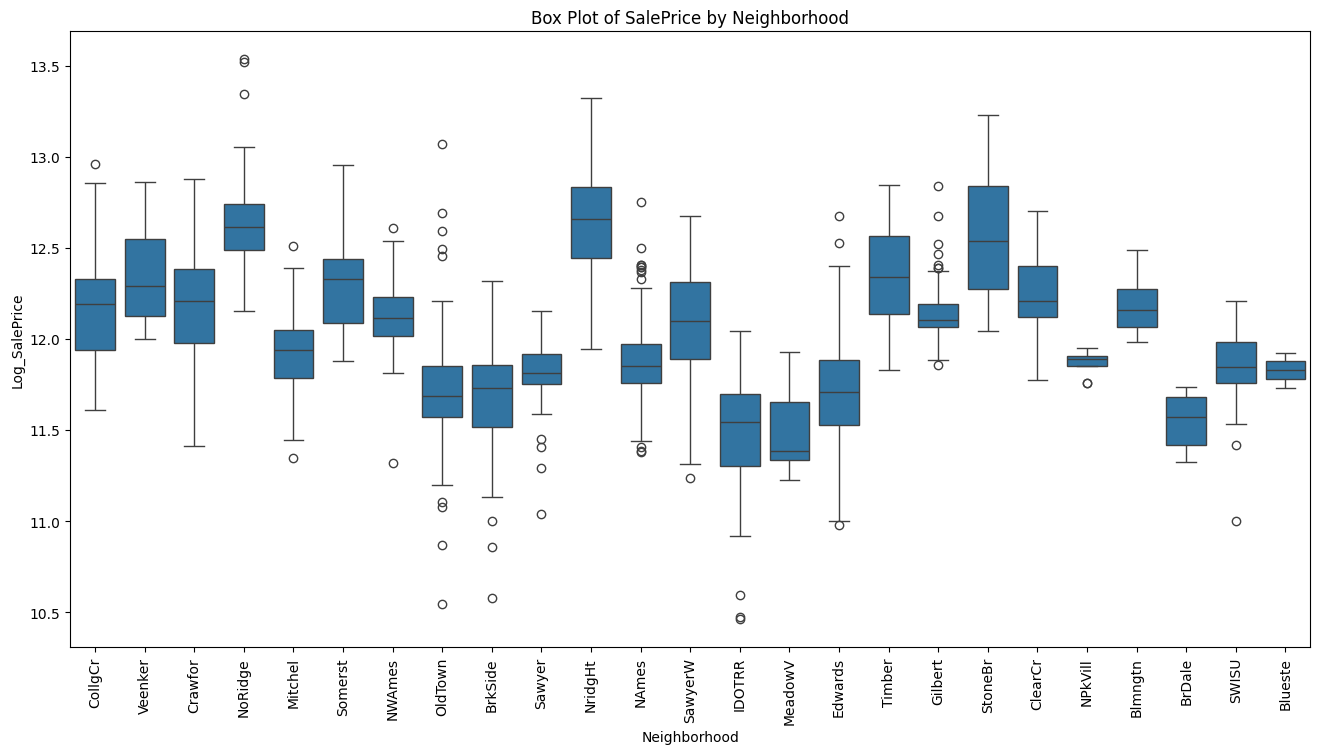

In [7]:
# Vẽ box plot chart cho df theo neiborhood và saleprice
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(16,8))
sns.boxplot(x='Neighborhood', y='Log_SalePrice', data=df)
plt.xticks(rotation=90)
plt.title('Box Plot of SalePrice by Neighborhood')
plt.show()

In [8]:
# Dựa vào SalePrice by Neighborhood để binning chia ra 3 khu vực là Low, Medium, High
def binning_neighborhood(df):
    # Tính trung vị SalePrice cho từng Neighborhood
    neighborhood_median = df.groupby('Neighborhood')['Log_SalePrice'].median().sort_values()
    
    # Chia thành 3 nhóm bằng cách sử dụng quantiles
    low_threshold = neighborhood_median.quantile(1/3)
    high_threshold = neighborhood_median.quantile(2/3)
    
    # Hàm để gán nhãn khu vực
    def label_neighborhood(median_price):
        if median_price <= low_threshold:
            return 'Low'
        elif median_price <= high_threshold:
            return 'Medium'
        else:
            return 'High'
    
    # Áp dụng nhãn cho từng Neighborhood
    neighborhood_labels = neighborhood_median.apply(label_neighborhood)
    
    # Tạo cột mới trong df để lưu nhãn khu vực
    df['Neighborhood_Category'] = df['Neighborhood'].map(neighborhood_labels)
    
    return df

df = binning_neighborhood(df)

In [ ]:
def detect_outliers_and_apply_rules(df):
    

    # --- 1. Xác định Outlier Thống kê theo Từng Neighborhood (IQR Rule) ---
    
    print("Bước 1: Xác định Outlier thống kê theo từng Neighborhood (IQR)...")

    # Tính Q1, Q3, IQR cho SalePrice theo từng Neighborhood
    q1 = df.groupby('Neighborhood')['Log_SalePrice'].transform(lambda x: x.quantile(0.25))
    q3 = df.groupby('Neighborhood')['Log_SalePrice'].transform(lambda x: x.quantile(0.75))
    
    iqr = q3 - q1
    
    # Tính ngưỡng: Lower Bound và Upper Bound
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    
    # Tạo mask: True nếu là Outlier thống kê (nằm ngoài [LB, UB])
    outlier_mask = (df['Log_SalePrice'] < lower_bound) | (df['Log_SalePrice'] > upper_bound)
    
    # Tạo outlier_df: Dữ liệu được xác định là Outlier thống kê theo khu vực
    outlier_df = df[outlier_mask].copy()
    
    print(f"-> Tổng số Outlier thống kê được tìm thấy: {len(outlier_df)}")
    
    # Kiểm tra nếu không có outlier nào thì dừng lại
    if outlier_df.empty:
        print("Không có Outlier thống kê nào để áp dụng quy tắc.")
        return
    return outlier_df


outlier_df = detect_outliers_and_apply_rules(df)


# 3. Thêm cột Giá trung bình theo Neighborhood vào outlier_df

if not outlier_df.empty:
    # 3.2. Tính Giá trung bình (SalePrice gốc) theo Neighborhood trên DataFrame GỐC
    avg_price_by_neighborhood = df.groupby('Neighborhood')['SalePrice'].mean().reset_index()
    avg_price_by_neighborhood.rename(columns={'SalePrice': 'AvgPrice_Neighborhood'}, inplace=True)
    
    # 3.3. Thêm cột AvgPrice_Neighborhood vào outlier_df
    outlier_df_final = pd.merge(
        outlier_df,
        avg_price_by_neighborhood,
        on='Neighborhood',
        how='left'
    )
    columns_order = ['Id', 'Neighborhood', 'Neighborhood_Category', 'SalePrice', 'Log_SalePrice', 'AvgPrice_Neighborhood','OverallQual','YearBuilt','ExterQual', 'GrLivArea']
    outlier_df_final = outlier_df_final[columns_order]
    outlier_df_final.to_csv('outliers_with_avg_price.csv', index=False)
else:
    print("\nKhông có dòng outlier nào được phát hiện.")

Bước 1: Xác định Outlier thống kê theo từng Neighborhood (IQR)...
-> Tổng số Outlier thống kê được tìm thấy: 55
